# Import Libraries

In [2]:
library(rgdal)
library(gdata)
library(ggplot2)
library(dplyr)
library(lubridate)
library(RColorBrewer)
library(extrafont)
library(stringr)

In [3]:
# plot options
options(warn=-1, repr.plot.res = 90) # adjust plot size
theme_set(theme_grey(base_family='NanumGothic'))

# Load Data

In [5]:
# 빅콘 - 챔피언스 리그
# ns 홈쇼핑 2019 매출 데이터 및 시청률 데이터 & 2020년 6월 편성표 
hshop.sales <- read.xls("../data/00/2019sales.xlsx", skip = 1, header = TRUE)
hshop.view <- read.xls("../data/00/2019vrating.xlsx", skip = 1, header = TRUE)
hshop.test <- read.xls("../data/00/202006schedule.xlsx", header = TRUE)


In [6]:

# define column data type 
hshop.sales$방송일시 <- as.POSIXct(hshop.sales$방송일시)
hshop.sales$month <- as.factor(month(hshop.sales$방송일시))
hshop.sales$day <- as.factor(day(hshop.sales$방송일시))
hshop.sales$hour <- as.factor(hour(hshop.sales$방송일시))
hshop.sales$weekday <- factor(weekdays(hshop.sales$방송일시), levels = c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))
hshop.sales$sales <- as.numeric(gsub(",", "", hshop.sales$취급액))
hshop.sales$판매단가 <- as.numeric(gsub(",", "", hshop.sales$판매단가))
hshop.sales$volume <- as.numeric(hshop.sales$sales)/as.numeric(hshop.sales$판매단가)

In [7]:
# drop if sales == 50,000 or null
dim(hshop.sales) #38309 original
hshop.sales <- hshop.sales %>%
  filter(!is.na(sales)) %>%
  filter(sales != 50000) %>%
  as.data.frame() #35379 #drop 3,000

[1] 38309    14

### 월일별 평균 매출 

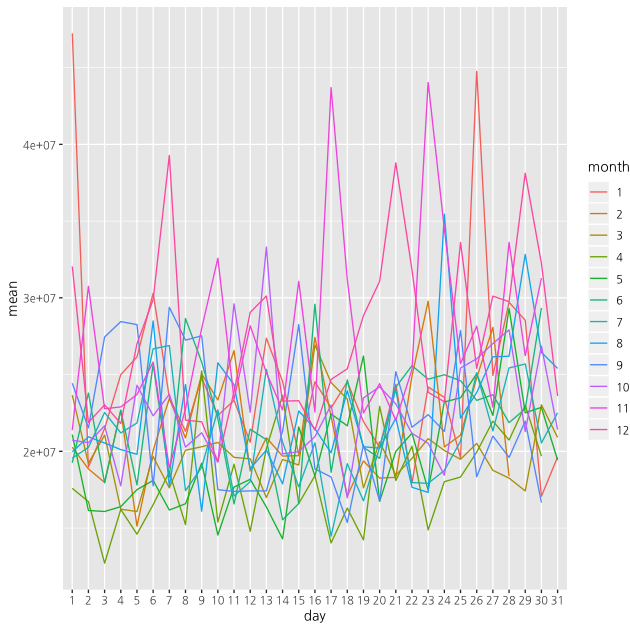

In [11]:
#monthly
md.sales = hshop.sales %>%
  group_by(month, day) %>%
  summarize(mean = mean(sales, na.rm = TRUE))
ggplot(md.sales, aes(x=day,y=mean,group=month))+
  geom_line(aes(color = month))

### 요일별 평균매출

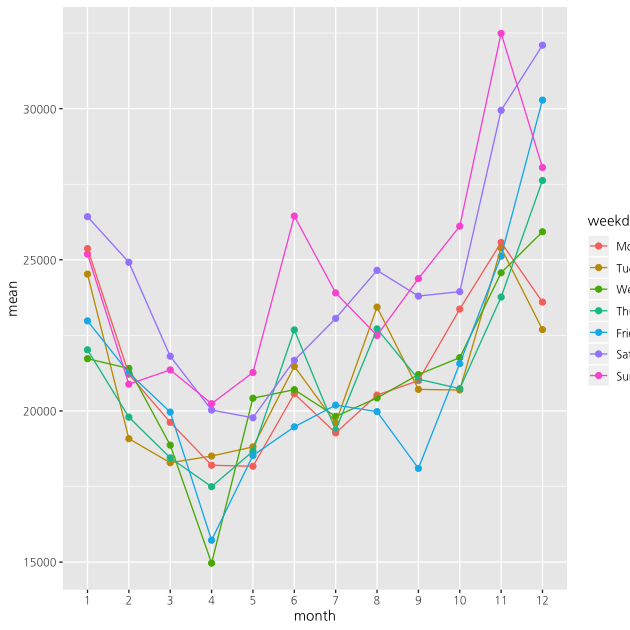

In [23]:
# 기본적으로 주말에 매출량이 많음
# 1,6,11월 정도가 피크
# 4월달에는 전체적으로 감소 --> 야외활동 영향?

# 평균매출액 기준
hshop.sales %>%
  group_by(month,weekday) %>%
  summarize(mean=mean(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=weekday,color=weekday)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) 


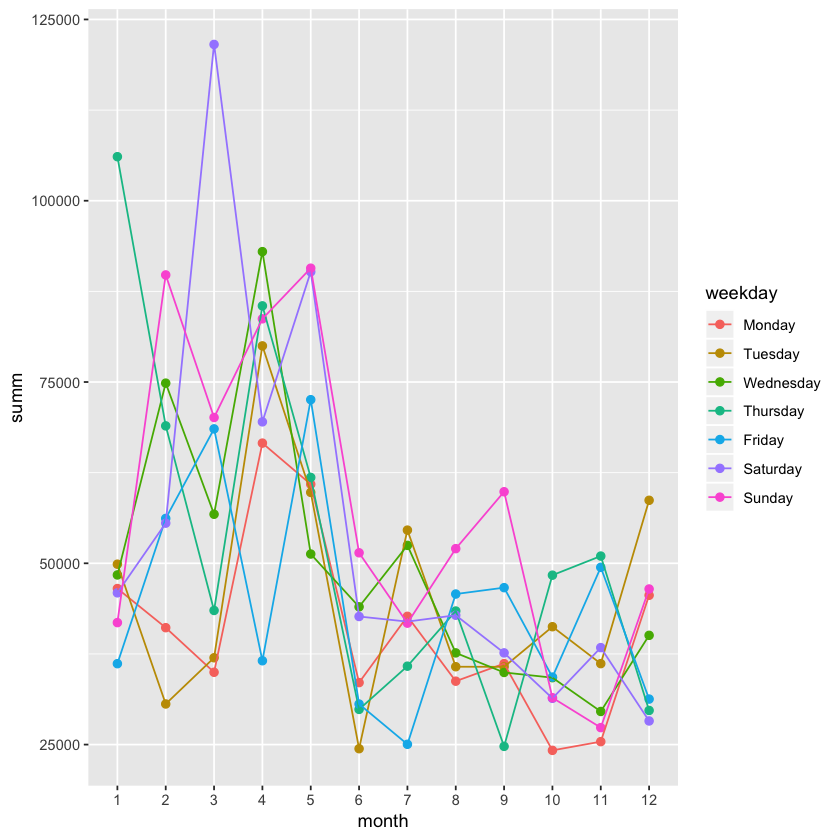

In [18]:
# 판매량합 기준
hshop.sales %>%
  group_by(month,weekday) %>%
  summarize(summ=sum(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=summ,group=weekday,color=weekday)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) 

평균매출액 기준으로 보면 4월의 평균매출액이 제일 낮고 11월부터 겨울 기간의 평균매출액이 제일 높은데
판매수량 기준으로 보면 오히려 3-5월이 높은 걸 확인할 수 있음 --> 판매품목의 차이?

### 품목별 월별 판매수량

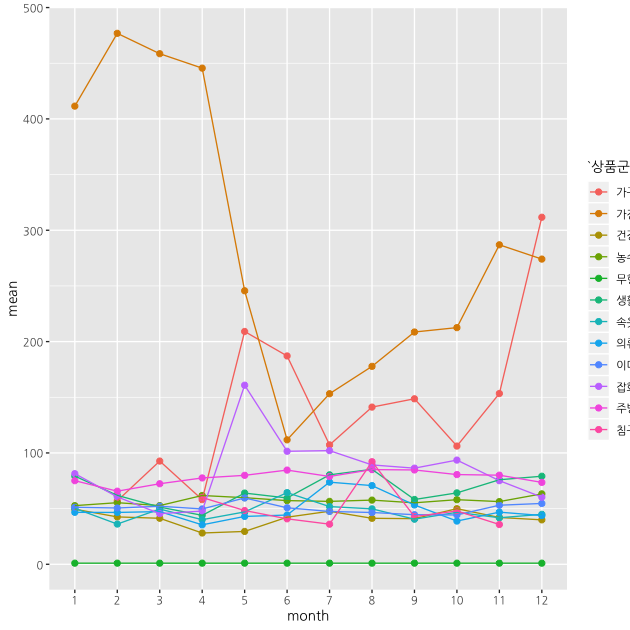

In [21]:
#by category+monthly
hshop.sales %>%
  group_by(상품군, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5)  


### 평일 시간대별 판매 수량

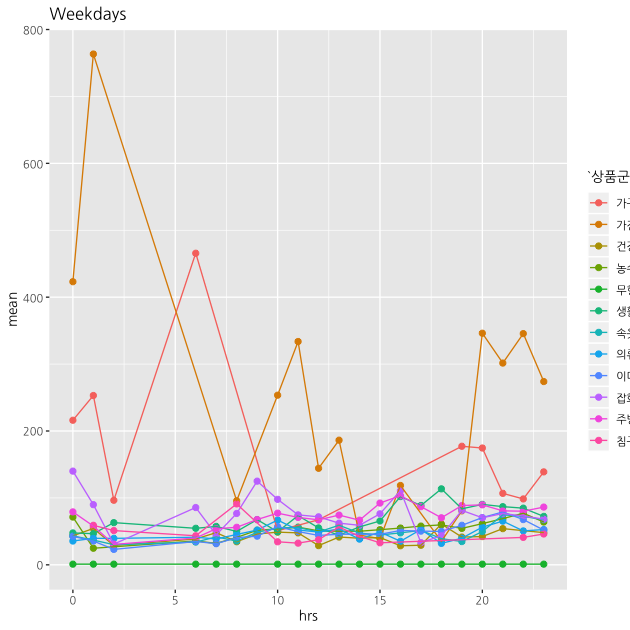

In [26]:
#by category+monthly
weekends <- c("Saturday", "Sunday")
hshop.sales %>%
  filter(!(weekday %in% weekends)) %>%
  mutate(hrs = hour(방송일시))%>%
  group_by(상품군, hrs) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=hrs,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) +
  ggtitle("Weekdays")

### 주말 시간대별 판매 수량

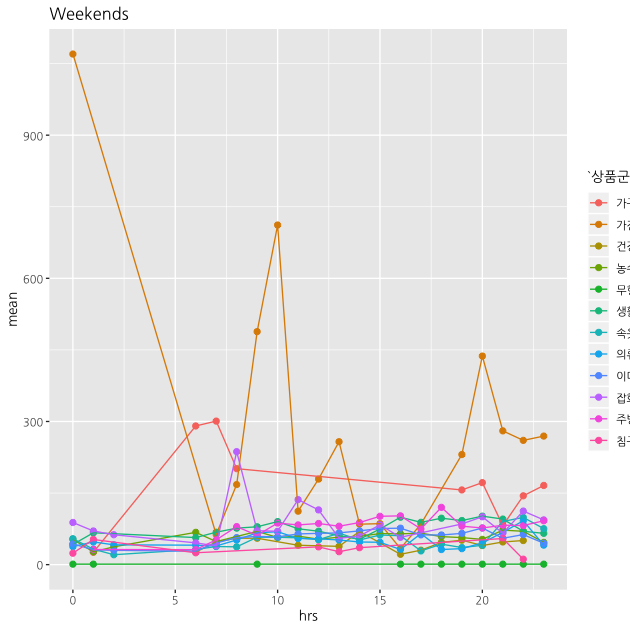

In [27]:

hshop.sales %>%
  filter((weekday %in% weekends)) %>%
  mutate(hrs = hour(방송일시))%>%
  group_by(상품군, hrs) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=hrs,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) +
  ggtitle("Weekends")


### 건강기능 품목 월별 평균 매출액 - 계절성 확인

상품명,mean
닥터 슈퍼 루테인,36466.33
제주농장 유기 양배추진액 120포,20711.12
종근당건강 프로메가 오메가3 파워,22666.83
통째로 착즙한 루비 석류즙 84포,41276.12
특집 이롬 황성주1일1생식 스페셜,10816.50


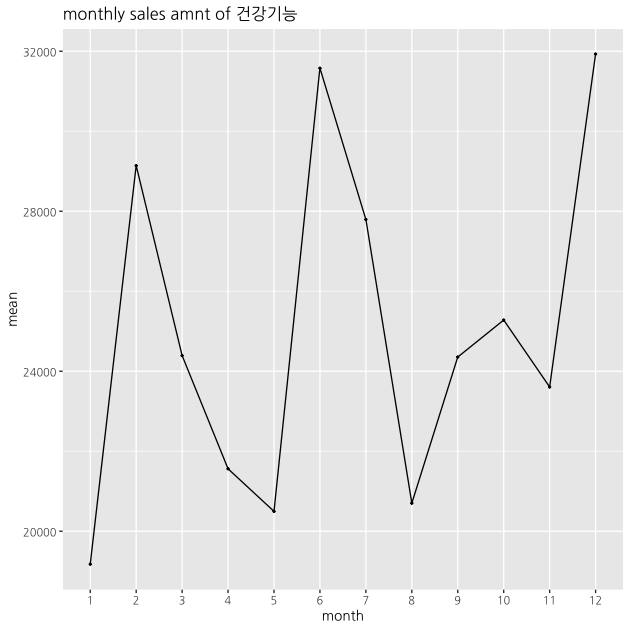

In [28]:

hshop.sales %>%
  select(month, 상품명, 상품군, volume, sales) %>%
  filter(상품군 == "건강기능") %>%
  group_by(month) %>%
  summarize(mean=mean(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean)) + 
  geom_point(size=0.5) +
  geom_line(aes(group = 1)) +
  ggtitle("monthly sales volume of 건강기능")

# 10월 건강기능 식품 판매목록
hshop.sales %>%
  select(month, 상품명, 상품군, volume, sales) %>%
  filter((상품군 == "건강기능") & (month == 2))  %>%
  group_by(상품명) %>%
  summarize(mean=mean(sales, na.rm = TRUE))  
#6,7월 여름에 다이어트 구미, 유산균 판매량 높음
#전반적으로 유산균, 루테인 판매율이 높음 - 네이버 인기 키워드와 유사

### 매출액 기준 인기상품 리스트

In [30]:
hot.items <- hshop.sales %>%
      group_by(마더코드) %>%
      summarize(summ=sum(sales, na.rm = TRUE)) %>%
      arrange(desc(summ)) %>%
      head(5) %>% # Top 5
      select(마더코드) %>%
      as.list()
# 1   100148 26362488
# 2   100074 22559131
# 3   100155 20301638
# 4   100837 20112241
# 5   100150 18940818
hshop.sales %>%
    select(month, 상품명, 상품군, volume, sales, 마더코드) %>%
    filter(마더코드 %in% hot.items$마더코드)  %>%
    group_by(마더코드) %>%
    mutate(mean = mean(sales, na.rm = TRUE)) %>%
    filter(row_number()==1) %>%
    select(상품명, 마더코드, mean) 

상품명,마더코드,mean
비버리힐스폴로클럽 남성기초세트(2018FW골드),100074,46227.73
일시불 LG 통돌이 세탁기,100150,31358.97
일시불 LG전자 매직스페이스 냉장고,100155,32744.58
일시불 LG 울트라HD TV 55UK6800HNC,100148,10069.71
(도냄)무이자 쿠쿠전기밥솥 10인용,100837,13345.88


### 판매수량별 인기상품

업데이트 예정

In [12]:
#hottest items(by volume)
hot.items.amnts <- hshop.sales %>%
  group_by(마더코드) %>%
  summarize(summ=sum(volume, na.rm = TRUE)) %>%
  arrange(desc(summ)) %>%
  head(5) %>%
  select(마더코드) %>%
  as.list()

hshop.sales %>%
    select(month, 상품명, 상품군, volume, sales, 마더코드) %>%
    filter(마더코드 %in% hot.items.amnts$마더코드)  %>%
    group_by(마더코드) %>% 
    mutate(sum=sum(volume, na.rm = TRUE)) %>%
    filter(row_number()==1) %>%
    select(상품명, 마더코드, sum) %>%
    as.list()

$상품명
[1] 국내산 손질갑오징어 8팩                    
[2] 멋진밥상 흥양농협 햅쌀 20kg                
[3] 비버리힐스폴로클럽 남성기초세트(2018FW골드)
[4] 안동간고등어 20팩                          
[5] AAB의 소곱창전골 800g x 8팩                
1770 Levels:   뉴트리원 다이어트 구미 ...

$마더코드
[1] 100322 100849 100074 100253 100010

$sum
[1] 227206.5 209864.6 566812.3 465758.9 213309.0

attr(,"groups")
# A tibble: 5 x 2
  마더코드 .rows    
     <int> <list>   
1   100010 <int [1]>
2   100074 <int [1]>
3   100253 <int [1]>
4   100322 <int [1]>
5   100849 <int [1]>

### Seasonal items

업데이트 예정

In [73]:
seasonal_items <- scan("seasonal_items.txt", character(), quote = "")

filtering.seasonal <- function(paras){
  
  if(paras[6] == "잡화" & paras[7] > 200000) return("명품잡화")
  else if (str_detect(paras[5], "김치냉장고")) return("김치냉장고")
  else if(str_detect(paras[5], "냉장고")) return("냉장고")
  else if(sum(str_detect(paras[5], c("에어컨","서큘레이터")))>0) return("냉방용품")
  else if(sum(str_detect(paras[5], c("공청기","공기청정기")))>0) return("공기청정기")
  else if(str_detect(paras[5], c("로보킹"))) return("청소기")
  else if(sum(str_detect(paras[5],seasonal_items)) > 0){
    return(seasonal_items[str_detect(paras[5],seasonal_items)])
  }
}



In [75]:
hshop.sales$season.item <- as.character(apply(hshop.sales,1,filtering.seasonal))
hshop.sales[hshop.sales$상품군 == "잡화" & hshop.sales$판매단가 > 200000, 14] <- "명품잡화"

### Monthly sales of seasonal items

In [13]:
hshop.sales %>%
  select(month, season.item, volume, sales) %>%
  filter(season.item != "NULL")  %>%
  group_by(season.item, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=season.item,color=season.item)) + 
  geom_point(size=0.5) +
  geom_line() +
  ggtitle("monthly sales of seasonality items")


ERROR: Error in .f(.x[[i]], ...): 객체 'season.item'를 찾을 수 없습니다


3월달에 확실히 미세먼지/황사관련 공기청정기, 의류관리기 매출 비중 커지고
신학기 노트북 매출액 증가 
김치냉장고, 냉장용품은 애초에 특정시기에만 판매
명품 5-6월에 특히 증가 - 가정의 달 영향?

In [14]:

hshop.sales %>%
  select(month, season.item, volume, sales) %>%
  filter(season.item != "NULL")  %>%
  group_by(season.item, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  filter(season.item == "명품잡화")



ERROR: Error in .f(.x[[i]], ...): 객체 'season.item'를 찾을 수 없습니다


# 여성/남성(의류)

상품군 == 의류에서 '남성' 키워드를 포함할 경우 return 1, ow 0

In [ ]:
hshop.sales$men <- NA
hshop.sales$men[hshop.sales$상품군 == "의류"] <- ifelse(str_detect(hshop.sales$상품명,"남성"), 1, 0)

# japping time

30분 단위로 (ex. 7시 20분 방송 시작  --> 7시) 방송시간 반올림.
타방송사 인기방송 고려해서 편성되는 점 반영하고자

In [18]:
filter.jappingt <- function(x){
  time <- x[1]
  if(minute(time) < 30 & hour(time) == 0){
    return(hour(time))
  }else if(minute(time) >= 30){
    if(hour(time) == 23) return(0)
    else return(hour(time) + 1)
  }else{
    if(hour(time) == 0) return(23)
    else return(hour(time))}
}
hshop.sales$japp <- as.factor(apply(hshop.sales, 1, filter.jappingt))

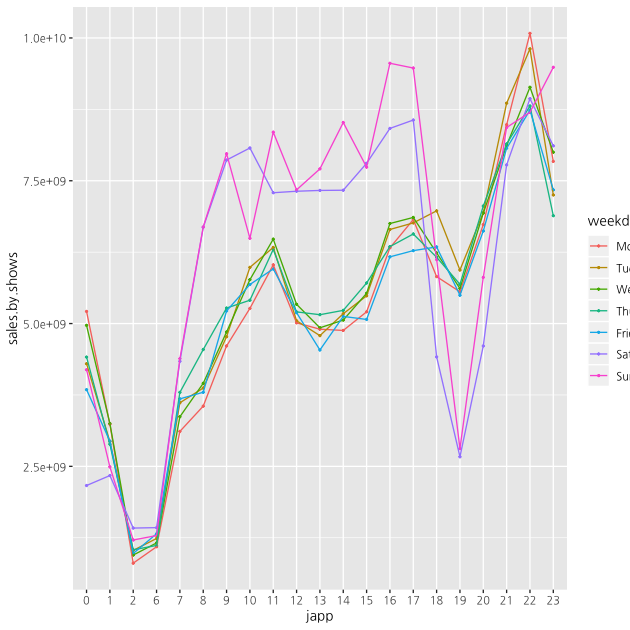

In [19]:
hshop.sales %>%
  select(japp, sales, weekday) %>%
  group_by(japp, weekday) %>%
  summarise(sales.by.shows = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=japp,y=sales.by.shows, group = weekday, color = weekday)) + 
  geom_point(size=0.5) +
  geom_line()

주말 19시 - 저녁먹을때/주말드라마 전에는 매출이 급격히 감소

아래 주문량 기준과 비교했을 때 peak time은 비슷하나 심야시간대 콜 수가 적은 반면 매출합이 굉장히 크다 --> 단가가 높은 제품을 판매하는 경향이 있다?

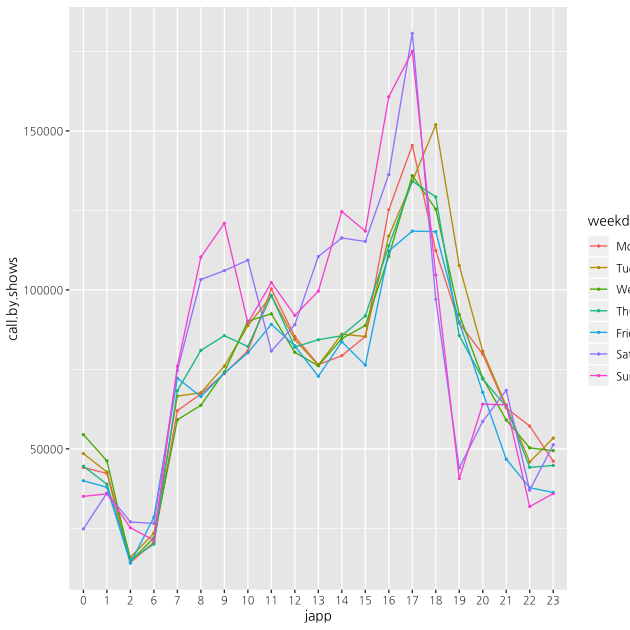

In [20]:
hshop.sales %>%
  select(japp, volume, weekday) %>%
  group_by(japp, weekday) %>%
  summarise(call.by.shows = sum(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=japp,y=call.by.shows, group = weekday, color = weekday)) + 
  geom_point(size=0.5) +
  geom_line()

# time slot

한 회차 기준 보통 2-3회에 나눠서 방송. 보통 마지막 time slot때 주문량이 급증한다고 하기 때문에 매출액에 연관성이 있지  않을까?

같은 방송 시간에 여러개의 상품코드를 팔 경우 각각 상품코드별로 count.
1-8 사이의 factor 리턴

! 같은 날짜에 다른 시간대로 같은 상품을 파는 경우/같은 타임에 방송했는데 마더코드가 다른 상품을 파는 경우 존재, 방송 시작시간+ 방영시간으로 같은 방송임을 반펼

In [21]:
# change colname 노출.분 to exposed.t
colnames(hshop.sales)[2] <- "exposed.t"

# 한 회차에 여러 상품 파는 경우
# 하나의 상품만 exposed.t 표기되어있음 -> 빈 값 impute
hshop.sales <- hshop.sales %>%
  group_by(방송일시) %>%
  mutate(exposed.t = mean(exposed.t, na.rm = TRUE)) %>%
  ungroup() %>%
  as.data.frame()

unique(hshop.sales$exposed.t)
# 여전히 NaN값 존재. -> 다음방송 시작 타임 - 해당방송 시작 타임 차이로 imputation

[1]  20  30  17 NaN  27  16  26  12   2  15  25   3  14  22  10  13  23  18   5
[20]   9  19   7  11  40

In [22]:
# 다음방송 시작 & 해당방송 시작 타임의 차이(in minutes)
min.diff <- hshop.sales %>%
  group_by(방송일시) %>%
  arrange(방송일시, 상품코드) %>%
  filter(row_number() == 1)%>%
  ungroup() %>%
  mutate(min.diff = as.numeric(방송일시 - lag(방송일시), units = 'mins'))%>%
  select(min.diff) %>%
  as.list()
min.diff <- min.diff$min.diff
min.diff <- c(min.diff[2:length(unique(hshop.sales$방송일시))], NA) #index 맞춰주기

# exposed.t가 빈값일 때 위에서 구한 min.diff 값 삽입
hshop.sales.hr <- hshop.sales %>%
  group_by(방송일시) %>%
  arrange(방송일시, 상품코드) %>%
  filter(row_number() == 1)%>%
  ungroup() %>%
  mutate(exposed.t = replace(exposed.t, is.na(exposed.t), min.diff[is.na(exposed.t)])) %>%
  as.data.frame() 

# exposed.t가 유독 큰 값이 있는지, 해당 상품과 시간 확인
hshop.sales.hr %>%
  filter(exposed.t > 40) %>%
  as.data.frame()

방송일시,exposed.t,마더코드,상품코드,상품명,상품군,판매단가,취급액,month,day,hour,weekday,sales,volume,hours_inweek,hours,japp
2019-08-07 01:30:00,270,100788,202340,루이띠에 순금 샤이닝 러브 팔찌 35g+골드바 1g,잡화,3650000,"5,810,000",8,7,1,Wednesday,5810000,1.591781,49,1,2


상식적으로 위 상품을 270분 동안 방영할리가 X, 2019-08-07 01:30 노출.분.(exposed.t) 누락되어있는 문제.

같은 상품의 직전 회차가 30분 방영되었기 때문에 직접 입력

In [23]:
hshop.sales.hr$exposed.t[format(hshop.sales.hr$방송일시,"%Y-%m-%d %H:%M") == "2019-08-07 01:30"] <- 30

unique(hshop.sales.hr$exposed.t)


[1] 20 30 17 27 16 26 12  2 15 25  3 14 22 10 13 23 18  5  9 19  7 11 40

특이사항 없어 보임

In [24]:
#hshop.sales.hr$exposed.t을 hshop.sales에 반영
for(i in 1:nrow(hshop.sales)){
  time <- hshop.sales$방송일시[i]
  exposed.min <- hshop.sales$exposed.t[i]
  if(is.na(exposed.min)){
    extracted.min <- hshop.sales.hr$exposed.t[hshop.sales.hr$방송일시 == time]
    hshop.sales$exposed.t[i] <- extracted.min
  }
}

In [25]:
# 한 time slot별로 그룹화(row가 방송1 timeslot)
# 이후 show.id, bp구할 때 용이하게끔
ts.schedule <- hshop.sales %>%
  mutate(ymd = format(방송일시, "%Y-%m-%d")) %>%
  group_by(방송일시) %>%
  filter(row_number() == 1)%>%
  as.data.frame

In [26]:
#### 0시 이후 방송이지만 전날 밤부터 이어서 파는 상품의 경우
#### ymd를 전날 기준으로 (방송시작 기준)
ts.schedule$ymd <- format(ts.schedule$방송일시, "%Y-%m-%d")
t <- 1
# 한 방송 당 최대 parttime이 9개
# 오늘의 첫방송과 어제 마지막 방송의 마더코드가 일치하고,
# 어제 마지막 방송의 시작 시간+ 방영시간 >= 오늘의 첫방송 시작 시간 이라면 같은 방송이라고 판단
while(t < 9){
  for (i in unique(ts.schedule$ymd)){
    if(i == "2019-01-01") next
    idx <- as.numeric(rownames(ts.schedule[ts.schedule$ymd == i,][1,]))
    first.show <- ts.schedule[idx,]
    last.show <- ts.schedule[idx-1,]
    if(first.show$마더코드 == last.show$마더코드 & first.show$방송일시 <= last.show$방송일시 + 60*last.show$exposed.t){
      ts.schedule$ymd[idx] <- ts.schedule$ymd[idx-1]}
  }
  t <- t + 1
}

In [31]:
# check
#  12월  8일 오후 11시 40분부터 12월 9일 오전 20분까지 세타임에 걸쳐서 같은 상품 판매
# ymd  똑같이 "2019-12-08" 로 입력
ts.schedule%>%
  filter(month ==  12  & as.numeric(day) >= 8 & 마더코드 ==  "100203")  %>%
  as.data.frame()

방송일시,exposed.t,마더코드,상품코드,상품명,상품군,판매단가,취급액,month,day,hour,weekday,sales,volume,hours_inweek,hours,japp,ymd
2019-12-08 23:40:00,20,100203,200703,(일)[보루네오] 피올레 천연소가죽 소파 3인용,가구,699000,"1,842,000",12,8,23,Sunday,1842000,2.635193,167,23,0,2019-12-08
2019-12-09 00:00:00,20,100203,200707,(일)[보루네오] 피올레 천연소가죽 소파 4인용,가구,899000,"7,323,000",12,9,0,Monday,7323000,8.145717,0,0,0,2019-12-08
2019-12-09 00:20:00,20,100203,200703,(일)[보루네오] 피올레 천연소가죽 소파 3인용,가구,699000,"11,355,000",12,9,0,Monday,11355000,16.244635,0,0,0,2019-12-08


In [33]:
# timeslot(parttime)
library(data.table)
ts.schedule <- transform(ts.schedule, parttime = ave(상품코드, rleid(ymd,상품코드), FUN = seq_along))

2019-10-27 06:00:00 판매하는 상품의 경우 같은 날짜에 두 번 따로 방송하는데, 위의 식으로는 parttime에 나눠서 반영되지 못하는 문제가 있어  아래와 같이 직접 입력

In [34]:
# 2019-10-27 06:00:00  
ts.schedule$parttime[16988:16990] <- c(1:3)

In [35]:
hshop.sales$parttime <- NA
for(i in 1:nrow(ts.schedule)){
  timeslot <- ts.schedule$방송일시[i]
  part <- ts.schedule$parttime[i]
  hshop.sales$parttime[hshop.sales$방송일시 == timeslot] <- part
}

In [36]:
hshop.sales$parttime <- as.factor(hshop.sales$parttime) #factor

In [39]:
sum(is.na(hshop.sales$parttime))

[1] 0

# show.id

일별 방송 회차. ex 2019년 10월 10일 4번째 방송 --> "2019-10-10 4" 형태로 리턴

In [40]:
ts.schedule$show.counts <- NA

In [41]:
for(i in unique(ts.schedule$ymd)){
  rtn <- ts.schedule[ts.schedule$ymd == i,]
  slot.count <- 0 #num of shows for each day
  for(j in 1:nrow(rtn)){
    if(rtn$parttime[j] == 1){
      slot.count <- slot.count + 1 #cum num of shows
      ts.schedule[ts.schedule$ymd == i,]$show.counts[j] <- paste(i, slot.count) #exp like "2019-01-01 1"
    }}
}

In [49]:
head(ts.schedule[,c(1,2,3,4,19,20)])

방송일시,exposed.t,마더코드,상품코드,parttime,show.counts
2019-01-01 06:00:00,20,100346,201072,1,2019-01-01 1
2019-01-01 06:20:00,20,100346,201072,2,NA
2019-01-01 06:40:00,20,100346,201072,3,NA
2019-01-01 07:00:00,20,100305,200974,1,2019-01-01 2
2019-01-01 07:20:00,20,100305,200974,2,NA
2019-01-01 07:40:00,20,100305,200974,3,NA


assign show.id only to the rows with parttime == 1, meaning the first time slot for each product                                                   

# min.range

위에서  구한 show.id 별 방송 길이

In [50]:
ts.schedule$min.range <- NA
for(i in 1:(nrow(ts.schedule))){
  if(ts.schedule$parttime[i] == 1){
    min.dur <- ts.schedule$exposed.t[i] # min for each time slot
    j <- i + 1
    while(ts.schedule$parttime[j] != 1){
      min.dur <- min.dur + ts.schedule$exposed.t[j]
      j <- j + 1
      if(j == nrow(ts.schedule)+1) break
    }
  }
  ts.schedule$min.range[i:(j-1)] <- min.dur
}

In [51]:
head(ts.schedule$min.range)

[1] 60 60 60 60 60 60

In [53]:
# check na
sum(is.na(ts.schedule$parttime))
sum(is.na(ts.schedule$min.range))

[1] 0

[1] 0

In [54]:
#show.id랑 min.range hshop.sales 파일에 통합
hshop.sales$min.range <- NA
hshop.sales$show.id <- NA
for(i in which(!is.na(ts.schedule$show.counts))){

  show.id <- ts.schedule$show.counts[i]
  timeslot <- ts.schedule$방송일시[i]
  minrange <- ts.schedule$min.range[i]
    
  hshop.sales$show.id[hshop.sales$방송일시 >= timeslot & 
                            hshop.sales$방송일시 < timeslot + 60*minrange] <- show.id 
    #time으로 같은 회차임을 판별, 해당하는값 삽입
  hshop.sales$min.range[hshop.sales$방송일시 >= timeslot & 
                          hshop.sales$방송일시 < timeslot + 60*minrange] <- minrange
}

In [55]:
head(hshop.sales[,c(1,3,4,5,16,17,18,19)])

방송일시,마더코드,상품코드,상품명,hours,japp,parttime,min.range
2019-01-01 06:00:00,100346,201072,테이트 남성 셀린니트3종,6,6,1,60
2019-01-01 06:00:00,100346,201079,테이트 여성 셀린니트3종,6,6,1,60
2019-01-01 06:20:00,100346,201072,테이트 남성 셀린니트3종,6,6,2,60
2019-01-01 06:20:00,100346,201079,테이트 여성 셀린니트3종,6,6,2,60
2019-01-01 06:40:00,100346,201072,테이트 남성 셀린니트3종,6,7,3,60
2019-01-01 06:40:00,100346,201079,테이트 여성 셀린니트3종,6,7,3,60


In [65]:
# check na
sum(is.na(hshop.sales$parttime))
sum(is.na(hshop.sales$show.id))
sum(is.na(hshop.sales$min.range))

[1] 0

[1] 1

[1] 1

In [70]:
row.names(hshop.sales.2019[is.na(hshop.sales.2019$show.id),])
#"23523" 
hshop.sales[23519:23524,c(1,2,3,4,18,19,20)]

[1] "23523"

,방송일시,exposed.t,마더코드,상품코드,parttime,min.range,show.id
23519,2019-08-28 12:00:00,10,100352,201144,1,50,2019-08-28 9
23520,2019-08-28 12:10:00,10,100352,201144,2,50,2019-08-28 9
23521,2019-08-28 12:30:00,10,100352,201144,3,50,2019-08-28 9
23522,2019-08-28 12:40:00,10,100352,201144,4,50,2019-08-28 9
23523,2019-08-28 12:50:00,10,100352,201144,5,NA,NA
23524,2019-08-28 13:00:00,20,100255,200868,1,60,2019-08-28 10


위 상품의 경우 2019-08-28 12:10:00 에 시작되는 회차가 10분 방영되지만 실제로 다음 회차까지 20분 텀이 있어서  마지막  회차가 제대로 카운트 되지 못함. 직접 입력해서 해결

In [71]:
hshop.sales$show.id[23523] <- hshop.sales$show.id[23522]
hshop.sales$min.range[23519:23523] <- 50

In [72]:
hshop.sales[23519:23524,c(1,2,3,4,18,19,20)]

,방송일시,exposed.t,마더코드,상품코드,parttime,min.range,show.id
23519,2019-08-28 12:00:00,10,100352,201144,1,50,2019-08-28 9
23520,2019-08-28 12:10:00,10,100352,201144,2,50,2019-08-28 9
23521,2019-08-28 12:30:00,10,100352,201144,3,50,2019-08-28 9
23522,2019-08-28 12:40:00,10,100352,201144,4,50,2019-08-28 9
23523,2019-08-28 12:50:00,10,100352,201144,5,50,2019-08-28 9
23524,2019-08-28 13:00:00,20,100255,200868,1,60,2019-08-28 10


# waiting time till the next event(vol+1)

 = 방송시간(min.range)/판매수량(volume) 

낮을수록 구매가 활발히 일어남. 상품코드별 distinct

In [ ]:
hshop.sales$sales.power <- NA
for (i in unique(hshop.sales$상품코드)){
  min.dur <- hshop.sales %>%
    filter(상품코드 == i)%>%
    group_by(show.id) %>%
    filter(row_number() == 1)%>%
    ungroup()%>%
    summarise(min.dur = sum(min.range, na.rm  = TRUE))%>% as.numeric()
  
  tot.amnt <- hshop.sales %>%
    filter(상품코드 == i) %>%
    summarise(tot.sales = sum(volume, na.rm = TRUE))%>% as.numeric()
  
  hshop.sales$sales.power[hshop.sales$상품코드 == i] <- min.dur/tot.amnt
}

In [38]:
# low
hshop.sales %>%
  group_by(상품코드) %>%
  filter(row_number() == 1) %>%
  filter(is.finite(sales.power)) %>%
  arrange(desc(sales.power)) %>%
  select(상품코드,  상품명, 상품군, sales.power, 판매단가) %>%
  head(10) %>%
  as.data.frame()


상품코드,상품명,상품군,sales.power,판매단가
201559,무)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2394.0,3990000
201564,일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2154.6,3591000
201555,(일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2154.6,3591000
201556,(일)한샘 하이바스 내추럴 하부장형,가구,1992.6,3321000
201554,(일)한샘 하이바스 내추럴 기본형 + 키큰장,가구,1992.6,3321000
200536,일시불 LG 휘센 싱큐 에어컨 2IN1형 FQ19V9KWA2,가전,1475.4,2459000
201762,일시불 삼성 무풍클래식 스탠드에어컨 AF17R7573WZK,가전,843.6,2109000
200492,무이자 LG트롬 건조기 14kg RH14VN(실버),가전,756.0,1890000
200559,일시불 LG트롬 건조기 14kg RH14VN(실버),가전,720.0,1800000
200560,일시불 LG트롬 건조기 14kg RH14WN(화이트),가전,680.0,1700000


In [39]:

# high
hshop.sales %>%
  group_by(상품코드) %>%
  filter(row_number() == 1) %>%
  filter(is.finite(sales.power)) %>%
  arrange((sales.power)) %>%
  select(상품코드, 상품명, 상품군, sales.power, 판매단가) %>%
  head(10) %>%
  as.data.frame()



상품코드,상품명,상품군,sales.power,판매단가
202064,고창 꿀 고구마 10kg,농수축,0.006532835,30900
201634,완도꼬마활전복 1.3kg,농수축,0.007869326,29900
200125,고칼슘검은콩두유48팩+호두아몬드 두유48팩,농수축,0.010037787,30900
201486,피시원 국내산 절단 햇 꽃게 2.4kg,농수축,0.010304382,49900
201036,LG생활건강 샤프란아우라 고농축 섬유유연제,생활용품,0.010408158,30900
200664,오델로 겨울모자 3종 (2차),잡화,0.010960897,29800
201955,영산포숙성홍어회7팩,농수축,0.010983615,29900
201322,코몽트 덤블 플리스 자켓 2종,의류,0.011086997,39900
201487,피시원 국내산 절단 햇 꽃게 7팩,농수축,0.011092600,49900
202063,강원도양구 간편시래기15팩,농수축,0.011727942,30900


단가가 낮아야 waiting time이 확실히 감소

# freq items 

방송 횟수가 잦은 상품들. 방송횟수 기준 탑 10의 상품코드

In [ ]:

hshop.sales %>%
  group_by(상품코드) %>%
  mutate(n.shows = n_distinct(show.id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(n.shows)) %>%
  head(10) %>%
  select(상품코드, 상품명, 상품군, n.shows) %>%
  as.data.frame()
# 간고등어, 한일대용량 믹서기, 세탁기

In [ ]:
hot.list <- hshop.sales %>%
  group_by(상품코드) %>%
  mutate(n.shows = n_distinct(show.id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(n.shows)) %>%
  head(10) %>%
  select(상품코드) %>%
  as.list()

In [ ]:
hshop.sales$hottest  <- NA
hshop.sales$hottest <- ifelse(hshop.sales$상품코드 %in% hot.list$상품코드, 1, 0)

In [ ]:
head(hshop.sales[hshop.sales$hottest == 1,]) #freq items

In [40]:
#write.csv(hshop.sales,"hshop_sales.csv", row.names = TRUE)

# 요일+시간 vs 168시간/주

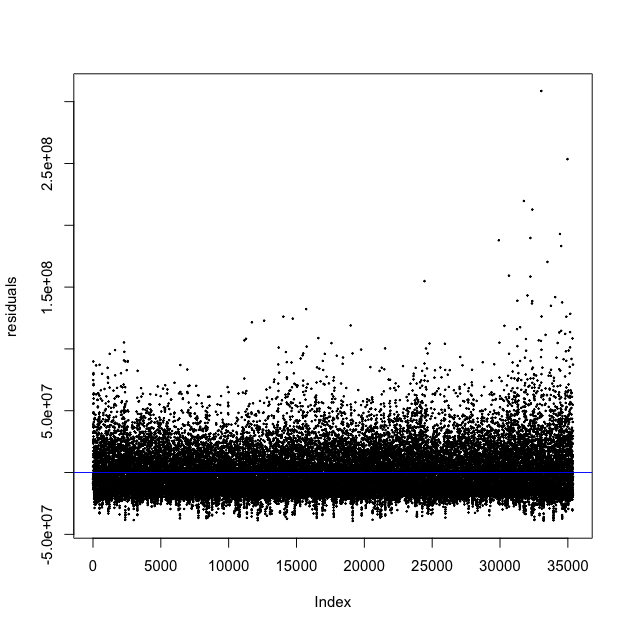

In [13]:
# weekday + hr
hshop.sales$hours <- as.factor(hour(hshop.sales$방송일시))
fit1 <- lm(sales ~ hours+weekday, data = hshop.sales)
plot(fit1$residuals, type = "p", cex = 0.2,  ylab = "residuals")
abline(h = 0, col = "blue")

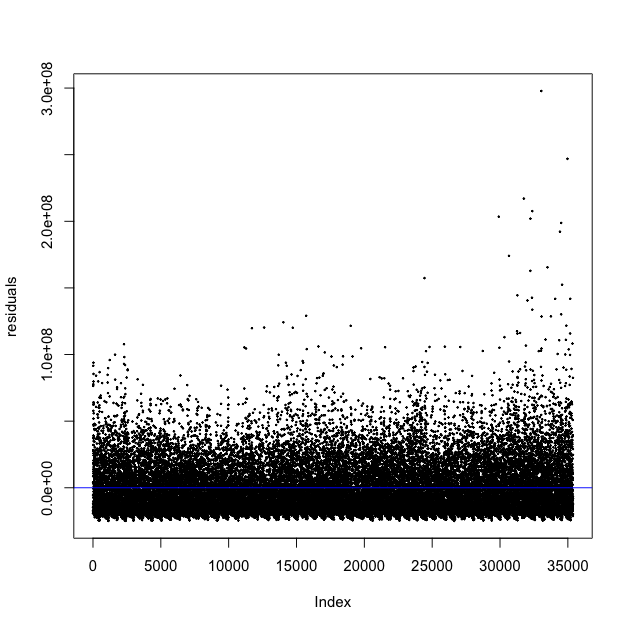

In [14]:
#168시간
hshop.sales$hours_inweek <- as.numeric(hshop.sales$weekday)*24-24+as.numeric(as.character(hshop.sales$hour))
fit2 <- lm(sales ~ hours_inweek, data = hshop.sales)
plot(fit2$residuals, type = "p", cex = 0.2,  ylab = "residuals")
abline(h = 0, col = "blue")


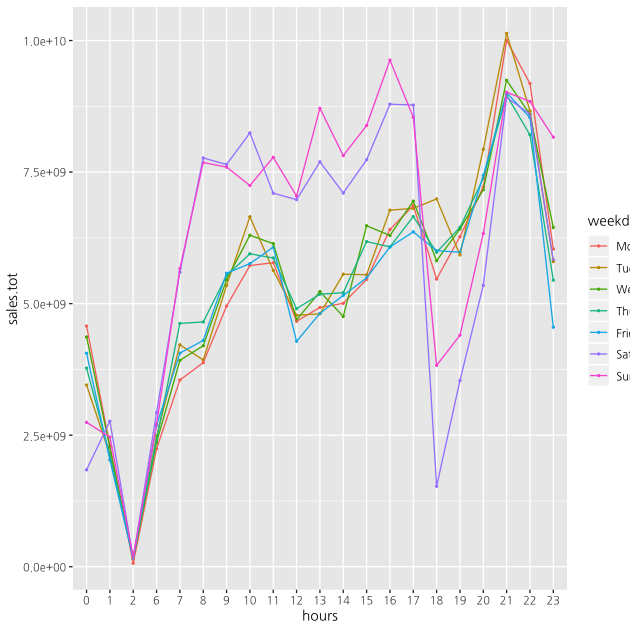

In [17]:
hshop.sales %>%
  group_by(hours, weekday) %>%
  summarise(sales.tot = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=hours,y=sales.tot, group = weekday, color = weekday)) + 
  geom_point(size=0.5) +
  geom_line()

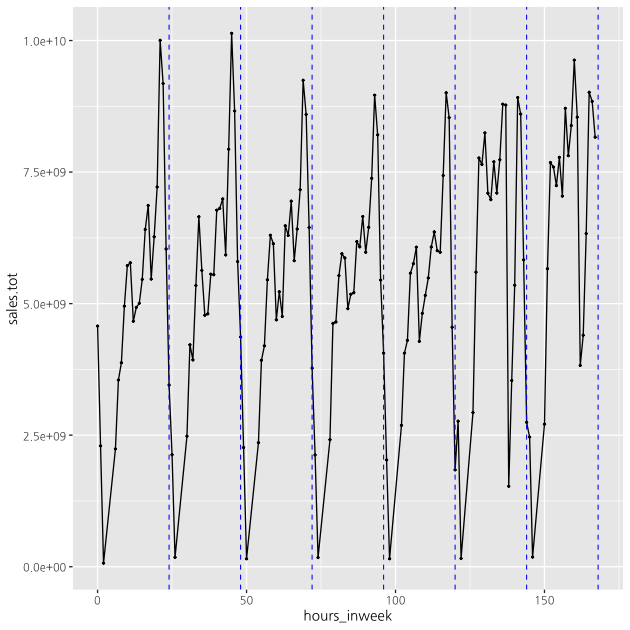

In [11]:
hshop.sales %>%
  group_by(hours_inweek) %>%
  summarise(sales.tot = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=hours_inweek,y=sales.tot)) + 
  geom_point(size=0.5) +
  geom_line() + 
  geom_vline(xintercept = 24*(1:7), linetype="dashed", 
                color = "blue", size=0.4)

# Data with categories